# Vision Transformer (ViT)

El Vision Transformer (ViT), propuesto por Dosovitskiy et al. (2020), utiliza una arquitectura basada en Transformers para tareas de visión por computadora. A diferencia de las CNN, el ViT aplica **Multi-Head Self-Attention (MHSA)** para modelar relaciones globales entre partes de la imagen.

## Arquitectura

El ViT divide las imágenes en **patches** y las convierte en una secuencia de vectores de características (embeddings), que luego se procesan mediante capas Transformer. A continuación, se aplica el mecanismo de self-attention para modelar las relaciones entre estos patches.

- **Embeddings**: Cada parche se aplana y se proyecta en un espacio de mayor dimensión.
- **Positional Encoding**: Se agrega un embebido posicional para cada parche, permitiendo que el modelo capture las posiciones espaciales.
---
## ¿Cómo funciona el Self-Attention en ViT?

Cada uno de los parches se considera un token similar a las palabras en el procesamiento del lenguaje natural (NLP).
En el mecanismo de Self-Attention, cada uno de estos tokens (parches) puede interactuar con los demás tokens. Para hacerlo, el modelo calcula tres vectores para cada token:

- **Query:** Representa qué está buscando el token.

- **Key:** Representa una descripción de los demás tokens.

- **Value:** Es la información que tiene cada token y que podría ser relevante para otros tokens.

Luego, se calculan las similitudes entre el *Query* de un token y el *Key* de todos los demás tokens, lo que genera una "puntuación de atención". Esta puntuación determina cuánta atención debe prestar un token a otros. El valor *Value* de cada token se pondera según esta puntuación, lo que permite que un token integre información de todo el resto de la imagen.

Este mecanismo es lo que permite que cada token (parche) en una imagen entienda no solo lo que está ocurriendo en su área local, sino también pueda considerar qué está sucediendo en otras partes de la imagen.

La fórmula utilizada para calcular la atención es:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

Donde:
- **$Q$ (queries)**, **$K$ (keys)**, y **$V$ (values)** son las proyecciones lineales de los embeddings de los patches.
- **$d_k$** es la dimensionalidad de las proyecciones, usada para escalar el producto punto y estabilizar el entrenamiento.

Este proceso se aplica en múltiples cabezas, lo que permite al modelo aprender distintas representaciones.

El mecanismo de self-attention utiliza las proyecciones:

$$Q = XW_Q, \quad K = XW_K, \quad V = XW_V$$

Donde $X$ es el input y $W_Q$, $W_K$, y $W_V$ son matrices de pesos aprendidos.

Después de aplicar el mecanismo de Self-Attention, los tokens se actualizan, ya que ahora tienen información de los demás tokens. Este proceso se repite varias veces en distintas capas de atención, profundizando la interacción entre los parches.

Salida Final: Después de aplicar múltiples capas de Self-Attention, el modelo agrupa los tokens procesados para predecir la clase de la imagen o realizar otras tareas de visión.


![Vision Transformer](vit_gif.gif)

*Crédito: [lucidrains](https://github.com/lucidrains/vit-pytorch)*


## Tareas:

1. **Implementar la arquitectura de un Vision Transformer**

2. **Ingresar y ajustar los parametros del modelo***

3. **Probar diferentes técnicas de data augmentation**

In [1]:
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/My Drive/CEIA_ViT_CristianMarino/raccoon.jpg'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys

trainer_path = '/content/drive/My Drive/CEIA_ViT_CristianMarino'

sys.path.insert(0, trainer_path)

from trainer import Trainer

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import numpy as np
import math
import os
import torch
from torch import Tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torch
from torchvision import datasets, transforms
import torch._dynamo
torch._dynamo.config.suppress_errors = True



In [4]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print('Dispositivo: ',device)
print('Torch version: ',torch.__version__)

# La configuración, carga y preprocesamiento
class ConfigPreprocess:
    def __init__(self, device: str, img_path: str, img_size: int, patch_size: int):
        self.device = device
        self.img_path = img_path
        self.img_size = img_size
        self.patch_size = patch_size
        self.test_img = self.load_image()

    def load_image(self):
        return TF.to_tensor(Image.open(self.img_path).resize((self.img_size, self.img_size))).unsqueeze(0).to(self.device)

    def extract_patches(self, image: Tensor) -> Tensor:
        patches = image.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(image.shape[0], -1, self.patch_size, self.patch_size)
        return patches


class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 8):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

# ACÁ USO EL CÓDIGO SUGERIDO POR OKSANA EN EL FEEDBACK DEL TP 1

class PositionalEncodingLearned(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super(PositionalEncodingLearned, self).__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x):
        return x+self.pos_embedding


# Parámetros
img_path = folder_path
img_size = 900
patch_size = 64
embed_dim = 8
patch_idx = 0  # El índice del parche para el cual queres visualiizar la codificación posicional

# Preprocesamiento
config = ConfigPreprocess(device,img_path, img_size, patch_size)

# Extracción de parches y visualización
patches = config.extract_patches(config.test_img.squeeze(0))

# Generación de embeddings
embedded_patches = PatchEmbedding(img_size, patch_size, 3, embed_dim).to(config.device)
patches = embedded_patches(config.test_img)

# Codificación posicional

num_patches = (img_size // patch_size) ** 2
try:
    positional_encoding = PositionalEncodingLearned(num_patches, embed_dim).to(config.device)
    pos_embeddings = positional_encoding(patches)

except Exception as e:
    print(f"Revise la existencia de la función PositionalEncodingLearned. Se produjo error durante la compilación: \n {e}.")


Dispositivo:  cuda
Torch version:  2.5.1+cu121


# Transformer Encoder

In [5]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, num_layers: int, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout,bias= False)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        return self.transformer_encoder(x)

# Vision Transformer
Model
>
```ViT-Base ViT-Large ViT-Huge
    Layers Hidden size D 12 768
    24 1024 32 1280
    MLP size Heads
    Params
    3072 12 86M 4096 16 307M 5120 16 632M
```


In [6]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=900, patch_size=64, in_channels=3, embed_dim=768, num_heads=12, ff_dim=2048,
                 num_layers=12, dropout=0.1, num_classes=10):
        super(VisionTransformer, self).__init__()

        # Genero los embbedings de los parches
        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)

        # Defino el positional encoding
        num_patches = (img_size//patch_size)**2
        self.positional_encoding = PositionalEncodingLearned(num_patches, embed_dim)

        # TransformerEncoder
        self.transformer_encoder = TransformerEncoder(embed_dim, num_heads, ff_dim, num_layers, dropout)

        # Capa lineal con tantas neuronas como clases se quieren clasificar
        self.output = nn.Linear(embed_dim, num_classes)

    def forward(self, x):

        x = self.patch_embedding(x)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)

        x = x[:, 0]
        x = self.output(x)

        return x

# CIFAR10

In [7]:

# Define transformations for the input data
transform = transforms.Compose([
    #transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load your dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
def get_folder_size(folder_path :os.PathLike) -> str:
    total_size = 0
    for dirpath, _, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)

            if not os.path.islink(file_path):
                total_size += os.path.getsize(file_path)

    if total_size == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB")
    i = int(math.floor(math.log(total_size, 1024)))
    p = math.pow(1024, i)
    s = round(total_size / p, 2)
    return f"{s} {size_name[i]}"


folder_path = './data'
size_in_bytes = get_folder_size(folder_path)
print(f"Tamaño de carpeta: {size_in_bytes}")

Tamaño de carpeta: 340.19 MB


# Modelo

In [22]:
num_epochs = 10

model = VisionTransformer(
    img_size=32,
    patch_size=4,
    embed_dim=384,
    num_heads=12,
    ff_dim=3072,
    num_layers=12,
    dropout=0.1,
    num_classes=10
).to(device)


print("Parametros del modelo:", list(model.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)


model = model.to(device)


try:
    model = torch.compile(model)
except Exception as e:
    print("Se produjo error durante la compilación:", e)


Parametros del modelo: [Parameter containing:
tensor([[[[ 0.0780, -0.0983,  0.0589, -0.1159],
          [-0.1132,  0.0569,  0.0749, -0.0315],
          [-0.0669,  0.1153, -0.0749,  0.0110],
          [ 0.0589,  0.0293, -0.0829,  0.0056]],

         [[ 0.0914, -0.0644, -0.1334,  0.1411],
          [ 0.1390,  0.1115, -0.1374,  0.0335],
          [-0.0029, -0.0540,  0.0366, -0.1168],
          [ 0.0010,  0.0105, -0.1067, -0.0381]],

         [[-0.1101, -0.0503,  0.0931, -0.0299],
          [ 0.0044, -0.1030, -0.0822,  0.0456],
          [-0.0454,  0.0314,  0.0766,  0.0637],
          [-0.1075, -0.0121,  0.0150, -0.1128]]],


        [[[ 0.0363, -0.0273,  0.0610,  0.0562],
          [ 0.0152, -0.1075,  0.0677, -0.0675],
          [ 0.0322,  0.0942,  0.0624, -0.1077],
          [-0.0584, -0.0594, -0.0520, -0.0956]],

         [[ 0.0941,  0.0743, -0.0863, -0.1334],
          [-0.0922, -0.0747, -0.0142,  0.1012],
          [-0.0550, -0.1401, -0.1416,  0.1371],
          [ 0.0199,  0.0377, -0.

In [23]:
def count_parameters(model: nn.Module) -> int:
    """
    Count the number of trainable parameters in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model.

    Returns:
        int: The total number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000

torch.cuda.empty_cache()
print("Número de parámetros: {:.2f} millones".format(count_parameters(model)))

Número de parámetros: 35.45 millones


In [24]:
trainer = Trainer(model, train_loader,test_loader,criterion,optimizer, device)


for epoch in range(num_epochs):

    trainer.train_model(use_amp=True)

    scheduler.step()

loss 2.31289: 100%|██████████| 196/196 [05:54<00:00,  1.81s/it]


In [25]:
def evaluate_model(model, data_loader):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images = images.to(device).float()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    return accuracy, precision, recall, f1

# Evaluar el modelo
accuracy, precision, recall, f1 = evaluate_model(model, test_loader)


100%|██████████| 40/40 [00:19<00:00,  2.06it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.10
Precision: 0.01
Recall: 0.10
F1 score: 0.02


In [27]:
train_dataset.data[0].shape

(32, 32, 3)

  0%|          | 0/40 [00:00<?, ?it/s]


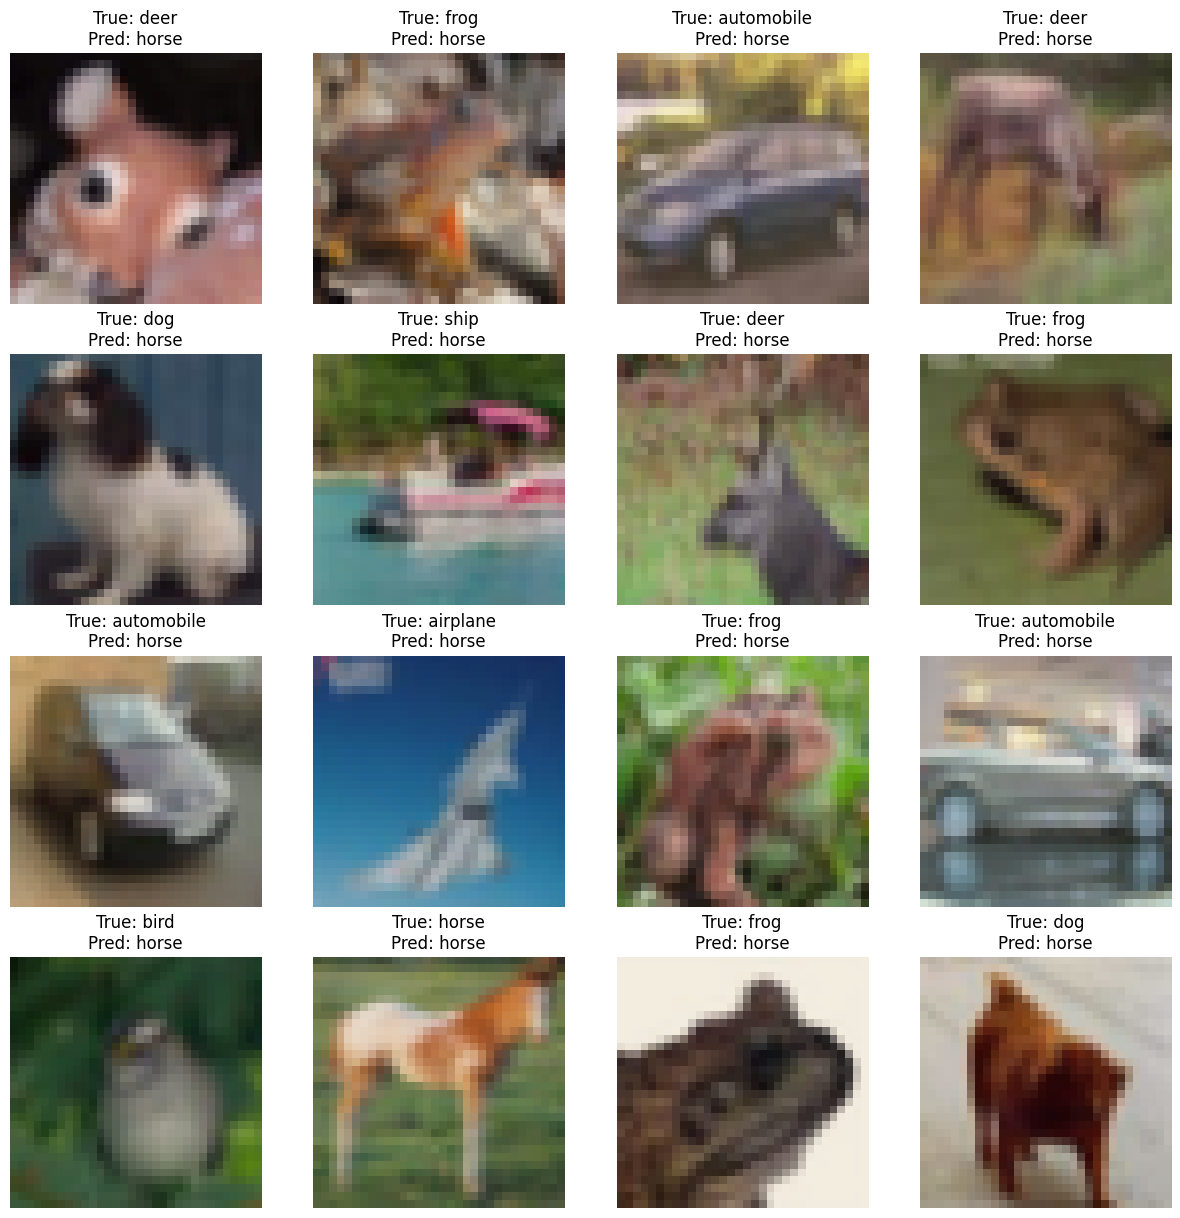

In [29]:

def visualize_classification(model, data_loader, class_names, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(data_loader)):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f'True: {class_names[labels[j]]}\nPred: {class_names[preds[j]]}')
                img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
                img = np.clip(img, 0, 1)
                ax.imshow(img)

                if images_so_far == num_images:
                    return

class_names = train_dataset.classes

visualize_classification(model, test_loader, class_names, num_images=16)
plt.show()


In [30]:
#DATA AUGMENTATION

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1),
    transforms.RandomResizedCrop((32, 32), scale=(0.75, 1.0), ratio=(0.8, 1.1)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [31]:
num_epochs = 10

model = VisionTransformer(
    img_size=32,
    patch_size=4,
    embed_dim=384,
    num_heads=12,
    ff_dim=3072,
    num_layers=12,
    dropout=0.1,
    num_classes=10
).to(device)


print("Parametros del modelo:", list(model.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)


model = model.to(device)


try:
    model = torch.compile(model)
except Exception as e:
    print("Se produjo error durante la compilación:", e)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Parametros del modelo: [Parameter containing:
tensor([[[[ 0.1235, -0.0962, -0.0496, -0.1077],
          [ 0.0762,  0.0518,  0.1165, -0.0257],
          [ 0.0419, -0.0434, -0.0730,  0.0034],
          [-0.0255,  0.0944,  0.0832,  0.0472]],

         [[ 0.1046,  0.0859, -0.0186, -0.0294],
          [ 0.1249, -0.0656, -0.0361,  0.0015],
          [ 0.0820, -0.0222, -0.0632, -0.0462],
          [-0.0855, -0.0927, -0.0925, -0.1097]],

         [[ 0.0995,  0.0161, -0.1073,  0.0095],
          [-0.1395, -0.1120, -0.0698, -0.1323],
          [-0.1037, -0.1434, -0.0126,  0.1342],
          [ 0.0364, -0.0587,  0.0995, -0.0876]]],


        [[[-0.0754,  0.0170, -0.1223,  0.0313],
          [-0.0845,  0.0237, -0.1178,  0.1148],
          [-0.0260, -0.1377,  0.0334,  0.0300],
          [-0.1313, -0.1154, -0.0175, -0.0268]],

         [[ 0.0514,  0.0718, -0.1081, -0.0160],
          [-0.0026, -0.1241,  0.0934,  0.0933],
          [ 0.0262,  0.0923, -0.0081,  0.0569],
          [-0.1020,  0.1253, -0.

In [33]:
trainer = Trainer(model, train_loader,test_loader,criterion,optimizer, device)


for epoch in range(num_epochs):

    trainer.train_model(use_amp=True)

    scheduler.step()

loss 2.31914: 100%|██████████| 196/196 [06:31<00:00,  2.00s/it]


In [34]:
def evaluate_model(model, data_loader):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images = images.to(device).float()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    return accuracy, precision, recall, f1

# Evaluar el modelo
accuracy, precision, recall, f1 = evaluate_model(model, test_loader)

100%|██████████| 40/40 [00:17<00:00,  2.26it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [35]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.10
Precision: 0.01
Recall: 0.10
F1 score: 0.02
